# The Swinging Door Algorithm (SDA) compression tool
Contributors: Karen Olsen


### Used for...
- Identifying Wind Ramping Events, Cui+15: https://ieeexplore.ieee.org/document/7293686
- Identifying Solar Power Ramping Events, Florita+15: https://www.osti.gov/biblio/1326715
- IBM Informix for handling e.g. Internet Of Things data: https://www.ibm.com/developerworks/community/blogs/9a743c4e-0bdb-4869-9da4-89b4aee6b562?lang=en

### Video presentation
https://youtu.be/89hg2mme7S0?t=106 by OSIsoftLearning, makers of the PI system application software for real-time data management.


### Setup
We start by importing some standard libraries and setting a nice style for plots

In [15]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

Load test data into pandas dataframe and take a look at it

In [16]:
data_df = pd.read_pickle('BO_DK_5min')
data_df.describe()

,OffshoreWindPower,OnshoreWindPower,TotalWindPower,TotalOnshoreWindPower,TotalOffshoreWindPower,TotalWindPower_BO,delta_time,time_steps
count,395275.000000,395275.000000,395275.000000,395275.000000,395275.000000,395275.000000,3.952750e+05,395275.0
mean,543.288103,945.253232,1488.541335,945.253232,543.288103,3.150104,5.929110e+07,300.0
std,368.493750,785.599589,1114.298965,785.599589,368.493750,7.125386,3.423186e+07,0.0
min,-90.030000,-93.910000,-2.470000,-93.910000,-90.030000,-1.000000,0.000000e+00,300.0
25%,205.980000,303.720000,536.865000,303.720000,205.980000,-1.000000,2.964555e+07,300.0
50%,505.610000,719.040000,1245.000000,719.040000,505.610000,-1.000000,5.929110e+07,300.0
75%,858.695000,1424.790000,2278.465000,1424.790000,858.695000,4.061314,8.893665e+07,300.0
max,1249.400000,15571.680000,16744.240000,15571.680000,1249.400000,29.995335,1.185822e+08,300.0


In [17]:
data_df.head()

,datetime,OffshoreWindPower,OnshoreWindPower,TotalWindPower,TotalOnshoreWindPower,TotalOffshoreWindPower,TotalWindPower_BO,delta_time,time_steps
0,2015-01-01 00:00:00,1032.33,1439.05,2471.38,1439.05,1032.33,-1.0,0.0,300.0
1,2015-01-01 00:05:00,1042.21,1422.34,2464.55,1422.34,1042.21,-1.0,300.0,300.0
2,2015-01-01 00:10:00,1021.80,1449.28,2471.08,1449.28,1021.80,-1.0,600.0,300.0
3,2015-01-01 00:15:00,1045.39,1445.87,2491.26,1445.87,1045.39,-1.0,900.0,300.0
4,2015-01-01 00:20:00,1059.79,1439.05,2498.84,1439.05,1059.79,-1.0,1200.0,300.0


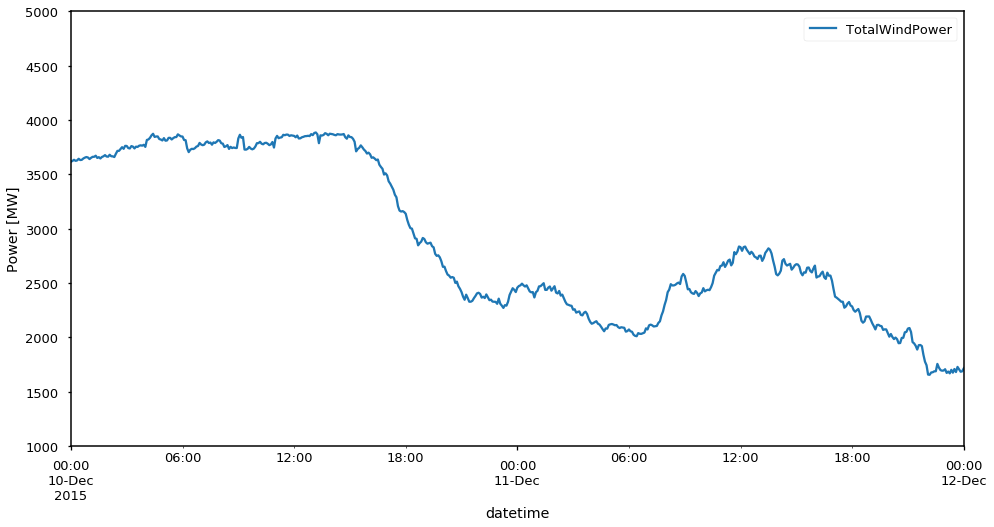

In [18]:
time_cut = [np.datetime64('2015-12-10'),np.datetime64('2015-12-12')]
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,1,1)
ax1.set_ylabel('Power [MW]')
data_df.plot(x='datetime',y='TotalWindPower',xlim=time_cut,ylim=[1000,5000],ax=ax1)

### Create function that will derive SDA

In [19]:
def SDA(data_df,data_name='',exc_dev=10,comp_dev=10,test_plot=False,time_cut=False):
    ''' Runs a Swinging Door Algorithm on data to look for ramps up and down.
    '''

    if test_plot:
        # TEST, cutting out part of data
        data_df = data_df[np.array([(data_df['datetime'].values > time_cut[0]) & (data_df['datetime'].values < time_cut[1])])[0]]
        
    datetime = data_df['datetime'].values
    delta_time = data_df['delta_time'].values
    data = data_df[data_name].values

    print('\nNow applying Exception test to data')

    # Calculate deviations from previous data point:
    new_segment         =   True
    index               =   0
    exc_keep            =   np.array(len(data_df)*[False])
    for _ in range(2*len(data_df)):
        if new_segment:
            # Just calculate min and max values
            min_val,max_val =   data[index]-exc_dev,data[index]+exc_dev
            new_segment     =   False
        else:
            # Calculate if point is outside valid range:
            inside          =   (min_val < data[index] < max_val)
            if not inside:
                exc_keep[index] = True
                exc_keep[index-1] = True
                new_segment = True
                index -= 1
            if inside:
                pass

        index += 1
        if index > len(data_df)-1: break

    exc_keep[0] = True
    exc_drop = [exc_keep == False]

    if test_plot:
        fig = plt.figure(figsize=(15,8))
        ax1 = fig.add_subplot(2,1,1)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Power [MW]')
        ax1 = plt.gca()
        ax1.plot(datetime[exc_drop],data[exc_drop],'ro',label='dropped after exception test',ms=3)
        ax1.plot(datetime[exc_keep],data[exc_keep],'bo',label='kept after exception test',ms=3)
        plt.legend()
    
    # Cut the data out that made it through the exception test
    print('original dataframe of %s rows' % len(data_df))
    red_data_df         =     data_df[exc_keep]
    print('reduced to %s rows after exception test' % len(red_data_df))
    delta_time = red_data_df['delta_time'].values
    data = red_data_df[data_name].values
    datetime = red_data_df['datetime'].values
    
    print('\nNow applying Swinging Door Algorithm to data')

    indices             =   []
    index               =   0
    recent_archive_time =   delta_time[0]
    for _ in range(2*len(red_data_df)):
        incoming_value      =   data[index]
        time                =   delta_time[index]
        time_step           =   time - recent_archive_time

        if index == 0:
            recent_archive_value = incoming_value
            recent_archive_time = time
            indices.append(index)
            # print('Very first point, keeping this index %s' % index)
            new_segment         =   True
        else:
            if new_segment:
                if time_step == 0:
                    # print('Very first point in this new segment, only storing value')
                    recent_archive_value = incoming_value
                    recent_archive_time = time
                else:
                    # print('First time step in new segment! Not sure yet, if keeping this index (%s)' % index)
                    current_snapshot_value = incoming_value #snapshot for next time...
                    max_slope       =   (incoming_value+comp_dev - recent_archive_value)/time_step
                    min_slope       =   (incoming_value-comp_dev - recent_archive_value)/time_step
                    # print('Slopes:')
                    # print(min_slope,max_slope)
                    new_segment = False
            else:
                # Calculate ref slope
                ref_slope       =   (incoming_value - recent_archive_value)/time_step
                # print('ref slope after %s sec: %s' % (time_step,ref_slope))
                # print(min_slope,max_slope,ref_slope)
                if not (min_slope < ref_slope < max_slope):
                    # print('point at index %s outside swinging door, go back one to start a new segment' % index)
                    # Start new segment with this incoming value as new archive value
                    recent_archive_value = data[index-1]
                    recent_archive_time = delta_time[index-1]
                    new_segment         =   True
                    indices.append(index-1)
                    index               -=  2
                else:
                    # print('point at index %s within swinging door, set as new snapshot value')
                    # print('Previous index %s NOT kept' % (index-1))
                    current_snapshot_value = incoming_value #snapshot for next time...
                    # Do not store this index, but update max and min slopes
                    new_max_slope       =   (incoming_value+comp_dev - recent_archive_value)/time_step
                    new_min_slope       =   (incoming_value-comp_dev - recent_archive_value)/time_step
                    # Making sure that the opening narrows
                    max_slope           =   min(max_slope,new_max_slope)
                    min_slope           =   max(min_slope,new_min_slope)
        index           +=  1
        if index > len(red_data_df)-1: break

    print('Identified about %s ramps ' % (len(indices)))

    times_SDA       =   datetime[indices]
    data_SDA        =   data[indices]

    ramps           =   np.array([data[indices[_+1]] - data[indices[_]] for _ in range(len(indices)-1)])
    ramp_index      =   np.arange(len(times_SDA)-1)
    ramp_up_index   =   ramp_index[ramps > 0]
    ramp_do_index   =   ramp_index[ramps < 0]

    times_up_ramps  =   [[times_SDA[_],times_SDA[_+1]] for _ in ramp_up_index]
    data_up_ramps   =   [[data_SDA[_],data_SDA[_+1]] for _ in ramp_up_index]
    times_do_ramps  =   [[times_SDA[_],times_SDA[_+1]] for _ in ramp_do_index]
    data_do_ramps   =   [[data_SDA[_],data_SDA[_+1]] for _ in ramp_do_index]

    if test_plot:
        fig = plt.gcf()
        ax1 = fig.add_subplot(2,1,2)
        ax1.plot(times_SDA,data_SDA,'x',ms=15,mew=2,color='purple',label='SDA selected')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Power [MW]')
        for _ in range(len(times_up_ramps)):
            ax1.plot(times_up_ramps[_],data_up_ramps[_],'--',color='g')
        for _ in range(len(times_do_ramps)):
            ax1.plot(times_do_ramps[_],data_do_ramps[_],'--',color='r')
        plt.legend()
#         if fig_name: plt.savefig(d_plot+a.fig_name+'.pdf', format='pdf', dpi=500)

    durations_min   =   np.array([[times_SDA[_+1]-times_SDA[_]] for _ in ramp_index])/np.timedelta64(1, 'm')
    results         =   dict(ramp_durations_min=durations_min.flatten(),\
                            ramp_magnitudes=ramps,\
                            times_up_ramps=times_up_ramps,\
                            data_up_ramps=data_up_ramps,\
                            time_ramps=times_SDA[0:-1],\
                            )
    return(results)


### Run SDA on test data


Now applying Exception test to data
original dataframe of 575 rows
reduced to 189 rows after exception test

Now applying Swinging Door Algorithm to data
Identified about 16 ramps 


/home/karen/code/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


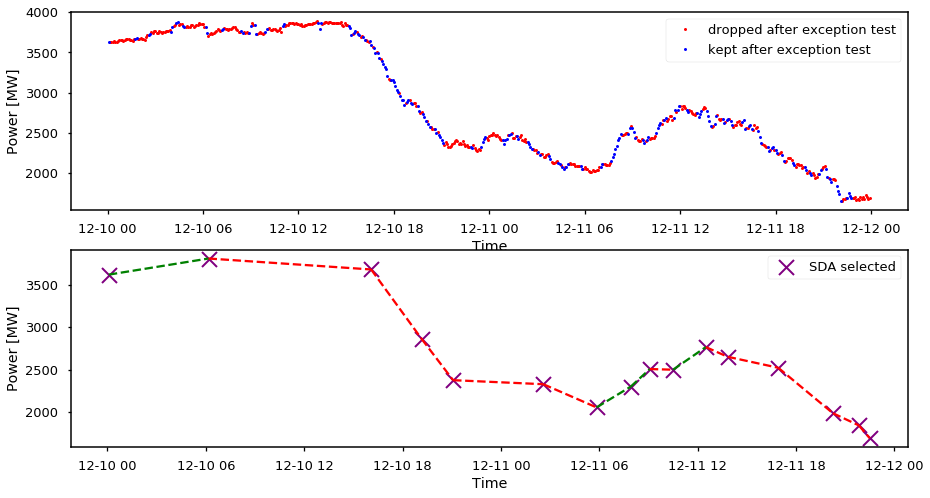

In [21]:
results = SDA(data_df,'TotalWindPower',exc_dev=50,comp_dev=150,test_plot=True,time_cut=time_cut)

Check out the distribution of ramp durations

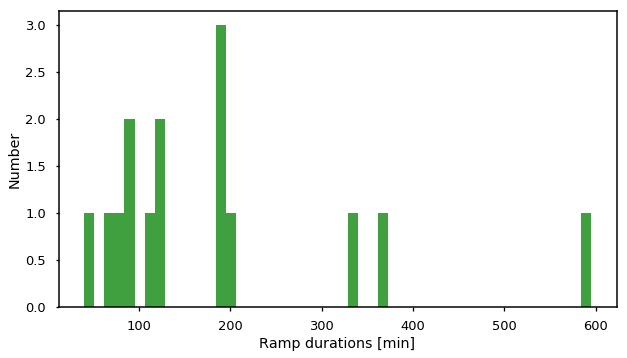

In [22]:
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(2,1,1)
ax1.set_xlabel('Ramp durations [min]')
ax1.set_ylabel('Number')
n, bins, patches = ax1.hist(results['ramp_durations_min'], 50, facecolor='g', alpha=0.75)

Repeat on entire dataset, to see full distribution

In [23]:
results = SDA(data_df,'TotalWindPower',exc_dev=30,comp_dev=130,test_plot=False,time_cut=time_cut)


Now applying Exception test to data
original dataframe of 395275 rows
reduced to 182841 rows after exception test

Now applying Swinging Door Algorithm to data
Identified about 11478 ramps 


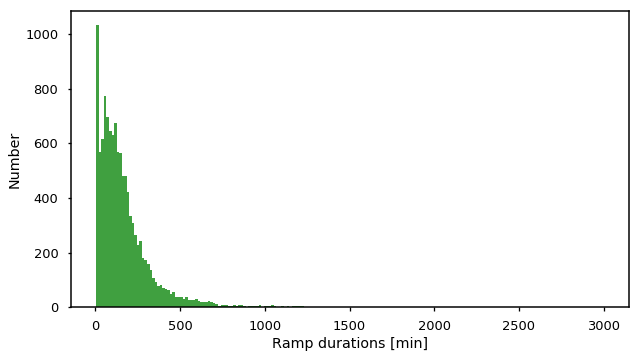

In [24]:
fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(2,1,1)
ax1.set_xlabel('Ramp durations [min]')
ax1.set_ylabel('Number')
n, bins, patches = ax1.hist(results['ramp_durations_min'], 200, facecolor='g', alpha=0.75)

### Doing this with your own modul (hiding the code)

In [25]:
import windpype as wp
power_ob = wp.CombPowerData(file_path='',file_name='BO_DK_5min')
power_ob.AddSDA(power_name='TotalWindPower',exc_dev=30,comp_dev=130,test_plot=False)

No method set for combining, will look for passed dataframe
No dataframe given, will look for saved file
Restored dataframe

Now applying Swinging Door Algorithm to TotalWindPower data
original dataframe of 395275 rows
reduced to 182841 rows after exception test
Identified about 11478 ramps 


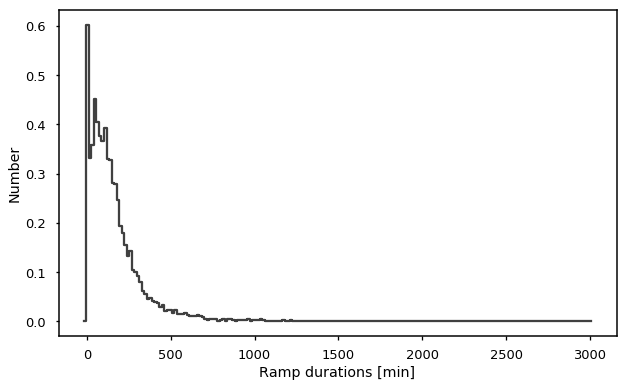

In [26]:
power_ob.PlotHisto(\
        histogram_values=['TotalWindPower_SDA_ramp_durations_min'],\
        colors=['k'],ls=['-'],alpha=0.75,\
        bins=200,max_val=False,log=False,ylab='Number',xlab='Ramp durations [min]')